In [2]:
import os
import pandas as pd
from datetime import datetime
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import contextily as ctx

import rasterio as rio
import rioxarray as rxr

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

## 1. Import Data

In [3]:
# cmap = ["#EE2617FF", "#F2A241FF", "#558934FF", "#0E54B6FF"] # CarolMan
cmap = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#A89F8EFF", "#9B6981FF", "#7887A4FF"] # Arches

In [4]:
fielddata = pd.read_csv('../../data/field_data/LWC_LFM_WP_dates20230525.csv')

fielddata['mpa_mean'] = fielddata['mpa_mean'] * -1   # data was collected as positive values

def parse_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d')
    except:
        return None
    
fielddata['date'] = fielddata.apply(lambda row: parse_date(row['date_wp']), axis=1)

def check_date_md(date):
    # check if date is within 8 days of any of the image dates
    for img_date in img_date_list:
        if abs((date - img_date).days) <= 8:
            return True
    return False

lwc = fielddata[['tree','time','species','date','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc = lwc[lwc['time'] == 'md']
lwc = lwc[lwc['lwc_mean'] < 1.4]   # indra says these very high values are most likely erroneous
lwc = lwc.drop_duplicates()

# Midday LWP data...
md_lwp = fielddata[['tree', 'time', 'species', 'mpa_mean', 'date']].copy().dropna()
md_lwp = md_lwp[md_lwp['time'] == 'md']
md_lwp = md_lwp.drop_duplicates()

In [5]:
cwc_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

# full_date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
date_list = ['20220429', '20220503', '20220511', '20220914'] # no field data on 5/17, georeferencing failed on 5/29, so this is what we've got
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.4998) & (df['CWC'] < 0.5) # dumb floating point bullsh*t
    df.loc[mask, 'CWC'] = np.nan
    return df

cwc_file_paths = [os.path.join(cwc_data_dir, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers, then sync up the rest of the data into one big dataframe
cwc = kill_nans(pd.read_csv(cwc_file_paths[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope'])).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    other_df = kill_nans(other_df)
    cwc = cwc.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})

# now make a list of dataframes containing all the good stuff
cwc_df_list = []
for date, file_path in zip(date_list, cwc_file_paths):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list.append(cwc_df)

# # check for fielddata collected within 4 days of 5/17/2022
# this_date = datetime(2022, 5, 17)
# fielddata[(fielddata['date'] >= this_date - pd.Timedelta(days=8)) & (fielddata['date'] <= this_date + pd.Timedelta(days=8)) & (fielddata['time'] == 'pd')]

In [6]:
# align CWC data with the field data
def get_cwc_data_md(tree_id, date):
    # check if there is a cwc date within 4 days of the field data date
    for this_date in datetime_list:
        if abs((this_date - date).days) <= 4:
            try:
                return cwc.loc[tree_id, 'CWC_' + this_date.strftime('%Y%m%d')]
            except:
                return None
    return None

lwc['cwc_md'] = lwc.apply(lambda row: get_cwc_data_md(row['tree'], row['date']), axis=1)
lwc = lwc.dropna()

md_lwp['cwc_md'] = md_lwp.apply(lambda row: get_cwc_data_md(row['tree'], row['date']), axis=1)
md_lwp = md_lwp.dropna()
md_lwp

,tree,time,species,mpa_mean,date,cwc_md
2360,1478,md,blue oak,-2.221000,2022-04-27,0.174713
2375,2004,md,blue oak,-2.620667,2022-04-27,0.145611
2384,2005,md,blue oak,-2.733000,2022-04-27,0.134170
2399,2006,md,blue oak,-2.717000,2022-04-27,0.173530
2417,2007,md,blue oak,-2.426333,2022-04-27,0.145473
...,...,...,...,...,...,...
6448,2378,md,blue oak,-4.317000,2022-09-15,0.035850
6478,2379,md,blue oak,-4.870667,2022-09-15,0.037159
6484,2380,md,live oak,-3.496000,2022-09-15,0.127105
6504,2381,md,blue oak,-4.740667,2022-09-15,0.080980


## 2. Calculate and Plot Changes Over Time

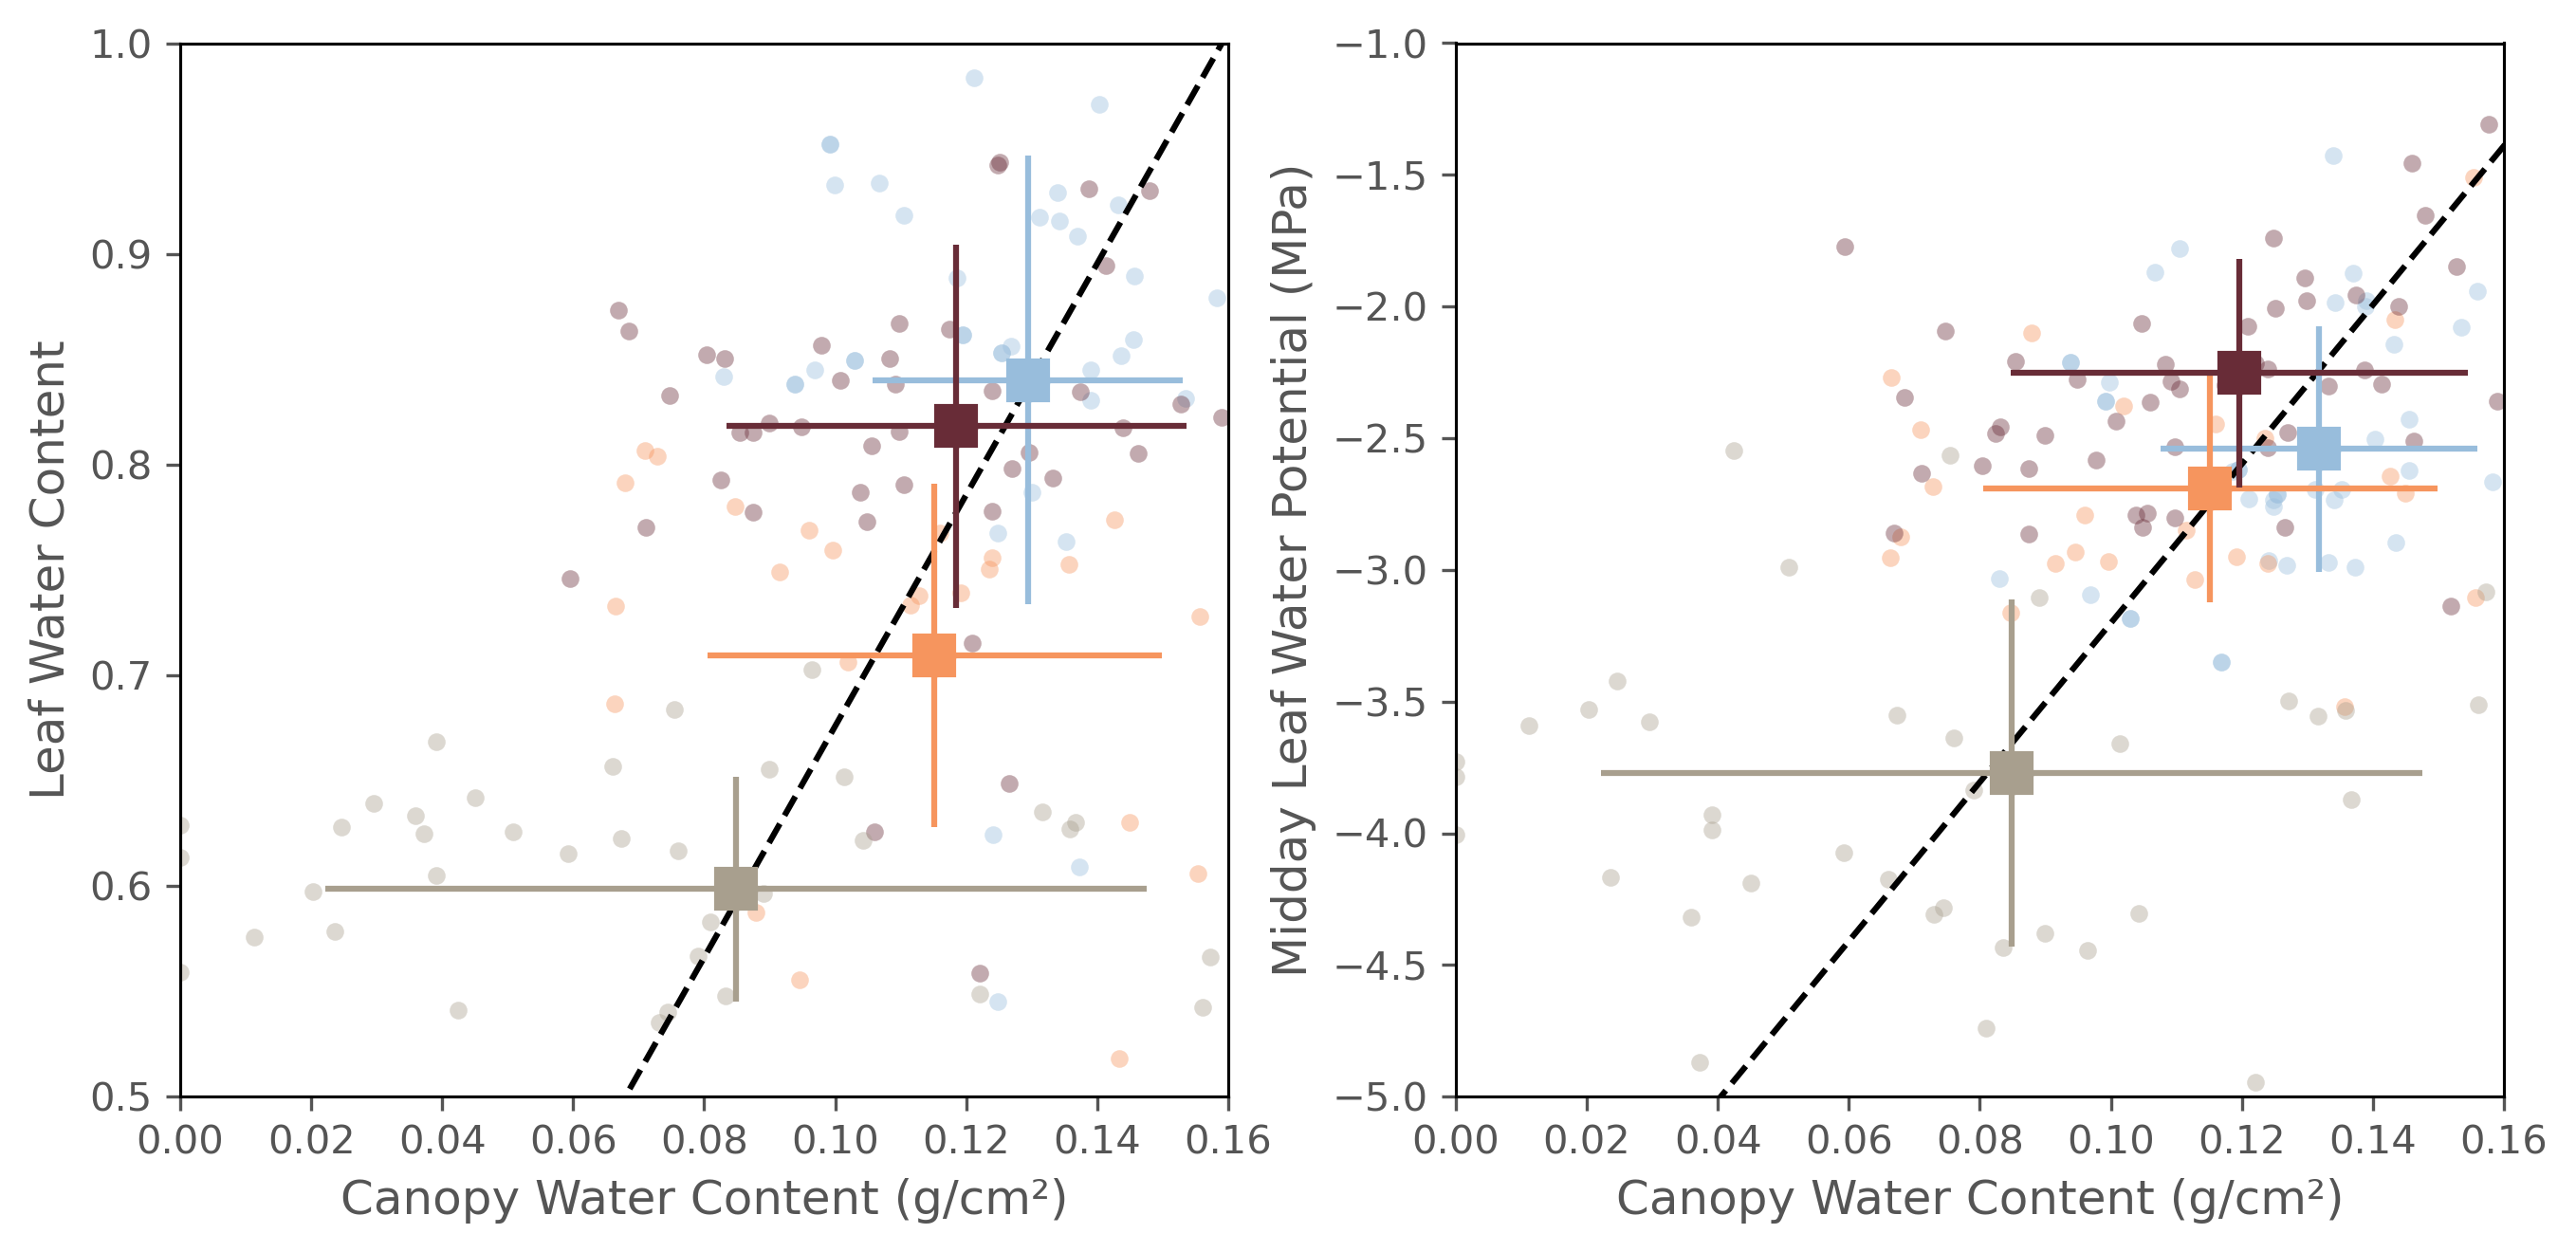

In [8]:
cwc_means = []
lwc_means = []
lwp_means = []
cwc_stds = []
lwc_stds = []
lwp_stds = []

fig, axs = plt.subplots(1,2, figsize=(9,4.5))
axs[0].set_facecolor('white')
# axs[0].grid(color='gray', linestyle='-', linewidth=0.25)
for spine in axs[0].spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.75)

for i, date in enumerate(date_list):
    lwc_filtered = lwc[(lwc['date'] <= datetime_list[i] + pd.Timedelta(days=4)) & (lwc['date'] >= datetime_list[i] - pd.Timedelta(days=4))]
    lwc_filtered = lwc_filtered.dropna()
    cwc_means.append(lwc_filtered['cwc_md'].mean())
    cwc_std = lwc_filtered['cwc_md'].std()
    lwc_means.append(lwc_filtered['lwc_mean'].mean())
    lwc_std = lwc_filtered['lwc_mean'].std()
    ## Plotting the means
    axs[0].plot(cwc_means[i], lwc_means[i], 's', color=cmap[i], label='Mean', markersize=10, zorder=3)
    axs[0].errorbar(cwc_means[i], lwc_means[i], xerr=cwc_std, yerr=lwc_std, fmt='o', color=cmap[i], label='Mean', markersize=10, zorder=3)
    ## Plotting the individual points
    axs[0].scatter(lwc_filtered['cwc_md'], lwc_filtered['lwc_mean'], color=cmap[i], s=20, alpha=0.4, label='Individual points', linewidths=0, zorder=1)

# Plot regression of means...
x = np.array(cwc_means).reshape(-1, 1)
y = np.array(lwc_means).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
r2 = reg.score(x, y)
slope = reg.coef_[0][0]
intercept = reg.intercept_
axs[0].plot(np.array([0, 1]), np.array([intercept, slope + intercept]), color='black', linestyle='--', label=f'R² = {r2:.2f}', zorder=2)

axs[0].set_xlim(0, 0.16)
axs[0].set_ylim(0.5, 1)
axs[0].set_xlabel('Canopy Water Content (g/cm²)')
axs[0].set_ylabel('Leaf Water Content')


axs[1].set_facecolor('white')
# axs[2].grid(color='gray', linestyle='-', linewidth=0.25)
for spine in axs[1].spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.75)

cwc_means = []

for i, date in enumerate(date_list):
    md_lwp_filtered = md_lwp[(md_lwp['date'] <= datetime_list[i] + pd.Timedelta(days=4)) & (md_lwp['date'] >= datetime_list[i] - pd.Timedelta(days=4))]
    md_lwp_filtered = md_lwp_filtered.dropna()
    cwc_means.append(md_lwp_filtered['cwc_md'].mean())
    cwc_std = md_lwp_filtered['cwc_md'].std()
    lwp_means.append(md_lwp_filtered['mpa_mean'].mean())
    lwp_std = md_lwp_filtered['mpa_mean'].std()
    ## Plotting the means
    axs[1].plot(cwc_means[i], lwp_means[i], 's', color=cmap[i], label='Mean', markersize=10, zorder=3)
    axs[1].errorbar(cwc_means[i], lwp_means[i], xerr=cwc_std, yerr=lwp_std, fmt='o', color=cmap[i], label='Mean', markersize=10, zorder=3)
    ## Plotting the individual points
    axs[1].scatter(md_lwp_filtered['cwc_md'], md_lwp_filtered['mpa_mean'], color=cmap[i], s=20, alpha=0.4, label='Individual points', linewidths=0, zorder=1)

# Plot regression of means...
x = np.array(cwc_means).reshape(-1, 1)
y = np.array(lwp_means).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
r2 = reg.score(x, y)
slope = reg.coef_[0][0]
intercept = reg.intercept_
axs[1].plot(np.array([0, 1]), np.array([intercept, slope + intercept]), color='black', linestyle='--', label=f'R² = {r2:.2f}', zorder=2)

axs[1].set_xlim(0, 0.16)
axs[1].set_ylim(-5, -1)
axs[1].set_xlabel('Canopy Water Content (g/cm²)')
axs[1].set_ylabel('Midday Leaf Water Potential (MPa)')
plt.tight_layout()


# plt.savefig('CWC_LWC_MDLWP_over_time2.png')
plt.show()

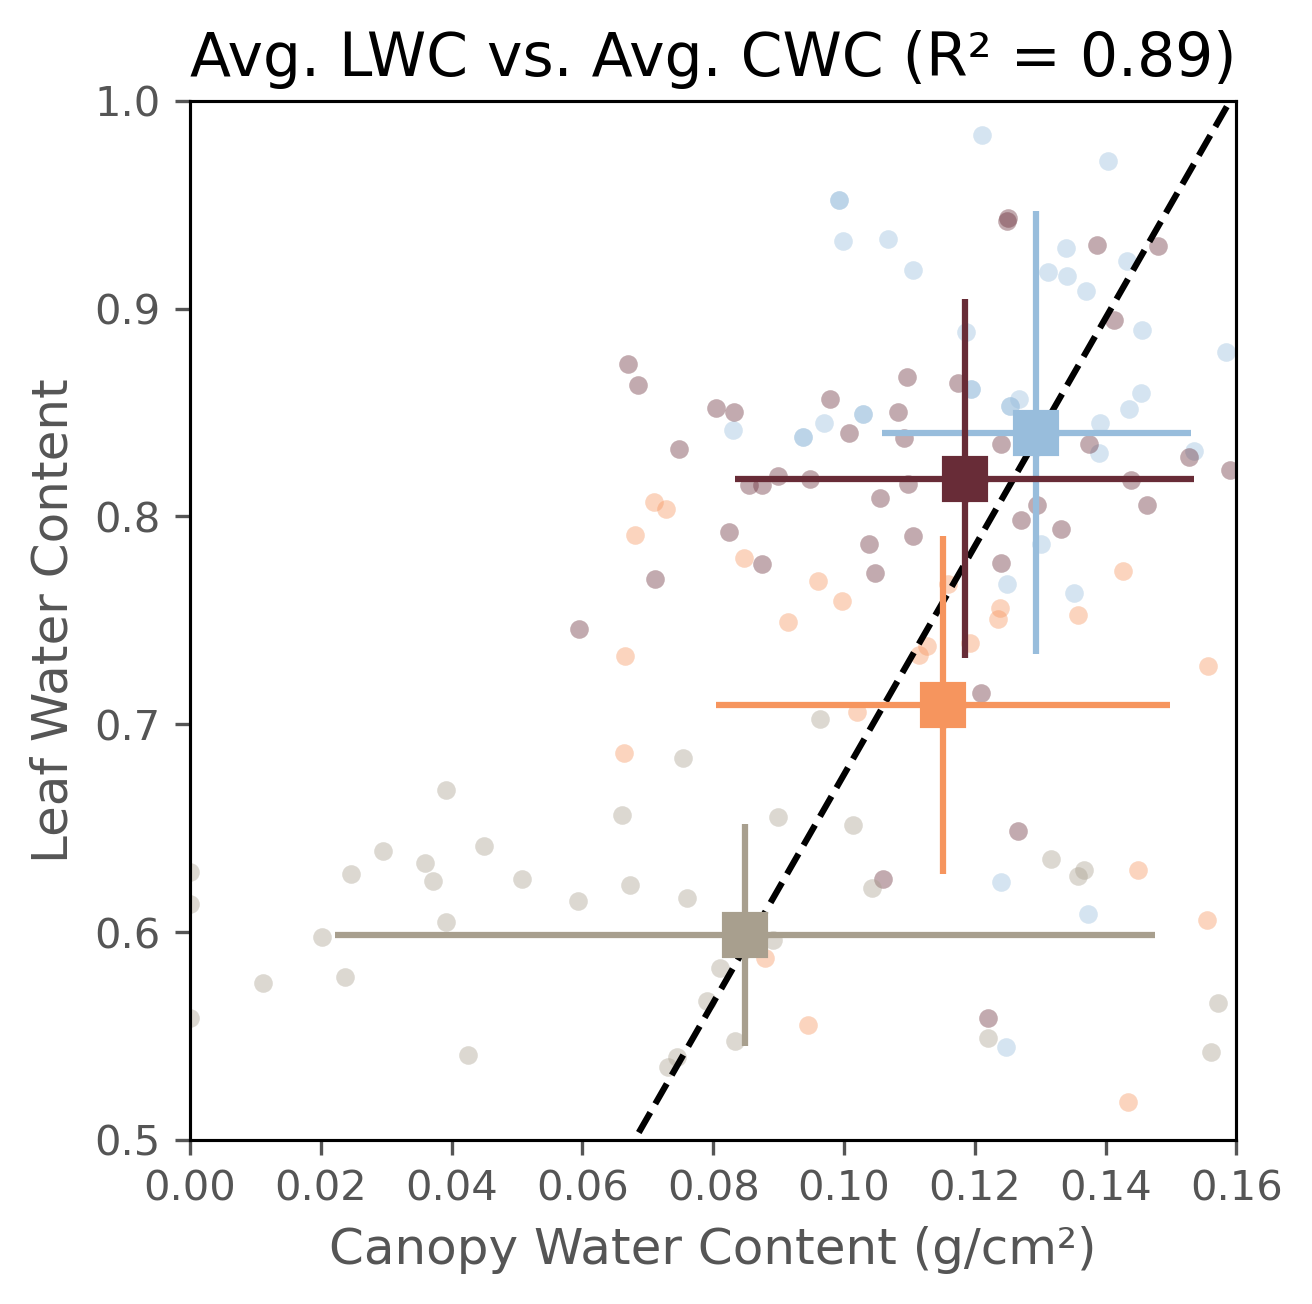

In [16]:
cwc_means = []
lwc_means = []
lwp_means = []
cwc_stds = []
lwc_stds = []
lwp_stds = []
fig, ax = plt.subplots(1,1, figsize=(4.5,4.5))
ax.set_facecolor('white')
# ax.grid(color='gray', linestyle='-', linewidth=0.25)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.75)

for i, date in enumerate(date_list):
    lwc_filtered = lwc[(lwc['date'] <= datetime_list[i] + pd.Timedelta(days=4)) & (lwc['date'] >= datetime_list[i] - pd.Timedelta(days=4))]
    lwc_filtered = lwc_filtered.dropna()
    cwc_means.append(lwc_filtered['cwc_md'].mean())
    cwc_std = lwc_filtered['cwc_md'].std()
    lwc_means.append(lwc_filtered['lwc_mean'].mean())
    lwc_std = lwc_filtered['lwc_mean'].std()
    ## Plotting the means
    ax.plot(cwc_means[i], lwc_means[i], 's', color=cmap[i], label='Mean', markersize=10, zorder=3)
    ax.errorbar(cwc_means[i], lwc_means[i], xerr=cwc_std, yerr=lwc_std, fmt='o', color=cmap[i], label='Mean', markersize=10, zorder=3)
    ## Plotting the individual points
    ax.scatter(lwc_filtered['cwc_md'], lwc_filtered['lwc_mean'], color=cmap[i], s=20, alpha=0.4, label='Individual points', linewidths=0, zorder=1)

# Plot regression of means...
x = np.array(cwc_means).reshape(-1, 1)
y = np.array(lwc_means).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
r2 = reg.score(x, y)
p_value = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]
slope = reg.coef_[0][0]
intercept = reg.intercept_
ax.plot(np.array([0, 1]), np.array([intercept, slope + intercept]), color='black', linestyle='--', label=f'R² = {r2:.2f}', zorder=2)

ax.set_xlim(0, 0.16)
ax.set_ylim(0.5, 1)
ax.set_xlabel('Canopy Water Content (g/cm²)')
ax.set_ylabel('Leaf Water Content')

ax.set_title('Avg. LWC vs. Avg. CWC (R² = ' + str(round(r2, 2)) + ')')

# plt.savefig('CWC_LWC_over_time.png')
plt.show()